In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Input
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

In [24]:
# Load and preprocess the data
df = pd.read_csv("ACB.VN.csv")
df.dropna(inplace=True)

In [25]:
# Convert the time column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Select column 'Close' as the dependent variable
df_Close = df[['Date', 'Close']]
# Reset the index of the DataFrame
df_Close = df_Close.reset_index(drop=True)

In [26]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df_Close['Close'] = scaler.fit_transform(np.array(df_Close['Close']).reshape(-1, 1))

# Split train, test set
train_size = int(0.7 * len(df_Close))
test_size = len(df_Close) - train_size

train_data = df_Close[:train_size]
test_data = df_Close[train_size:]

In [27]:
# Function to create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
# Reshape data

time_step = 100
X_train, y_train = create_dataset(train_data[['Close']].values, time_step)
X_test, y_test = create_dataset(test_data[['Close']].values, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [28]:

# Define GRU model
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(GRU(64))
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 3s 89ms/step - loss: 0.0570 - val_loss: 0.0016
Epoch 2/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0128 - val_loss: 0.0069
Epoch 3/100
13/13 [==============================] - 1s 50ms/step - loss: 0.0052 - val_loss: 0.0059
Epoch 4/100
13/13 [==============================] - 1s 78ms/step - loss: 0.0021 - val_loss: 4.2853e-04
Epoch 5/100
13/13 [==============================] - 1s 82ms/step - loss: 8.8588e-04 - val_loss: 8.7169e-04
Epoch 6/100
13/13 [==============================] - 1s 84ms/step - loss: 5.3820e-04 - val_loss: 3.2354e-04
Epoch 7/100
13/13 [==============================] - 1s 90ms/step - loss: 4.9658e-04 - val_loss: 3.2433e-04
Epoch 8/100
13/13 [==============================] - 1s 50ms/step - loss: 4.8952e-04 - val_loss: 3.0575e-04
Epoch 9/100
13/13 [==============================] - 1s 53ms/step - loss: 4.7189e-04 - val_loss: 3.1134e-04
Epoch 10/100
13/13 [==============================] - 1s

In [29]:
# Predict test data
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

# Normalize prediction data
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Reshape test data and inverse transform if necessary
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler.inverse_transform(y_test)

# Assuming y_pred_test is already in the shape required for inverse transform
y_pred_test = y_pred_test.reshape(-1, 1)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)

10/10 [==============================] - 0s 11ms/step


In [30]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error,mean_absolute_error
# Calculate MAPE for test set
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)

# Calculate RMSE for test set
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)

# Calculate MSLE for test set
test_MAE = mean_absolute_error(y_test_inv, y_pred_test_inv)

print('Test MAPE:', test_MAPE)
print('Test RMSE:', test_RMSE)
print('Test MAE:', test_MAE)

Test MAPE: 0.0101780566397235
Test RMSE: 307.16596517887496
Test MAE: 218.96561034513675


In [31]:
# Prediction function for a certain period of time
def predict_future_days(model, data, days, time_step):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape(1, time_step, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())

    return lst_output

# Predict the next 30, 60, 90 days
future_30_days = predict_future_days(model, test_data['Close'].values, 30, time_step)
future_60_days = predict_future_days(model, test_data['Close'].values, 60, time_step)
future_90_days = predict_future_days(model, test_data['Close'].values, 90, time_step)

# Create new predicted date range
last_index_date = df_Close['Date'].iloc[-1]
predict_dates_30 = pd.date_range(start=last_index_date + pd.Timedelta(days=1), periods=30)
predict_dates_60 = pd.date_range(start=last_index_date + pd.Timedelta(days=1), periods=60)
predict_dates_90 = pd.date_range(start=last_index_date + pd.Timedelta(days=1), periods=90)


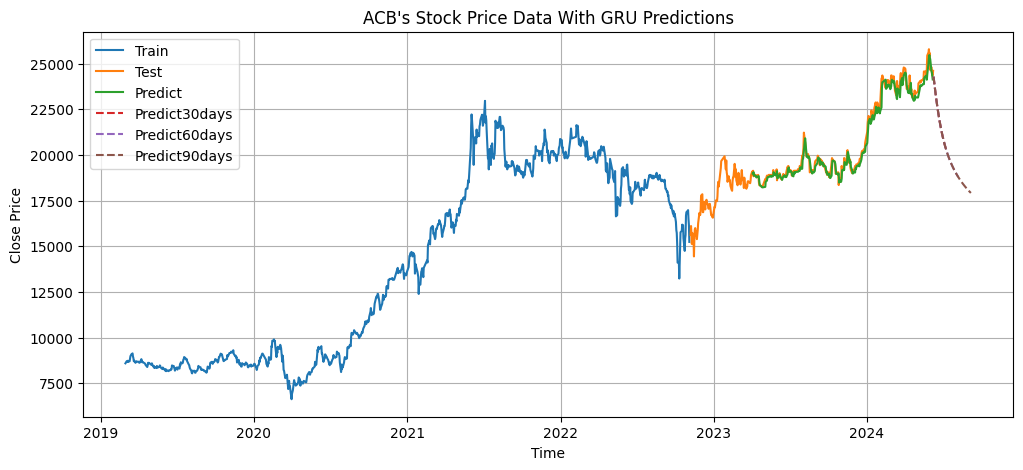

In [32]:
plt.figure(figsize=(12, 5))

plt.plot(df_Close['Date'][:train_size], scaler.inverse_transform(train_data[['Close']]))
plt.plot(df_Close['Date'][train_size:], scaler.inverse_transform(test_data[['Close']]))
plt.plot(df_Close['Date'][train_size + time_step:train_size + time_step + len(y_pred)], y_pred)
plt.plot(predict_dates_30, scaler.inverse_transform(future_30_days[:30]), linestyle='--')
plt.plot(predict_dates_60, scaler.inverse_transform(future_60_days[:60]), linestyle='--')
plt.plot(predict_dates_90, scaler.inverse_transform(future_90_days[:90]), linestyle='--')

plt.title("ACB's Stock Price Data With GRU Predictions")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(['Train', 'Test', 'Predict', 'Predict30days', 'Predict60days', 'Predict90days'])
plt.grid(True)
plt.show()